# Kernel Methods
`WORK IN PROGRESS`

## References
- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote13.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


plt.style.use("fivethirtyeight")

%matplotlib inline

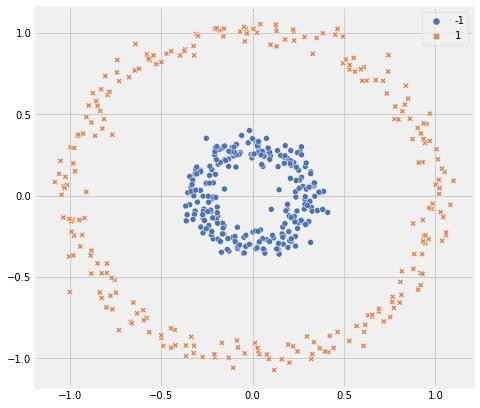

In [2]:
from sklearn.datasets import make_circles, make_swiss_roll

X, y = make_circles(n_samples=500, noise=0.05, shuffle=True, random_state=11, factor=0.3)
y = np.where(y == 0, 1, -1) # to change classes from 0, 1 to -1, 1

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y, ax=ax, palette='deep')
plt.show()

## Linear 

\begin{align}
K(x, z) &= x^T z
\end{align}

## Radian Basis Function (RBF) / Gaussian Kernel

\begin{align}
K(x, z) &= e^{\big( - \frac{|| x - z ||^2}{2 \sigma^2}\big)} \text{ or } \gamma = \frac{1}{2 \sigma^2} \\ \\
K(x, z) &= e^{\big( - {\gamma || x - z ||^2}\big)}
\end{align}

## Laplace
\begin{align}
K(x, z) &= e^{\big( - {\gamma | x - z |}\big)}
\end{align}

## Sigmoid


\begin{align}
K(x, z) &= \tanh{(a x^T z + c)}
\end{align}

## Polynomial

\begin{align}
K(x, z) &= (1 + x^T z)^d
\end{align}

## Implementation

In [3]:
# np.random.seed(0)

class Kernel:
    def __init__(self, name):
        self.name = name
        
    def _rbf(self, X, gamma=2):
        return np.exp(-gamma * np.linalg.norm(X, axis=1, ord=2))
    
    def _laplace(self, X, gamma=2):
        return np.exp(-gamma * np.linalg.norm(X, axis=1, ord=1))
    
    def _linear(self, X):
        return X[:, 0] * X[:, 1]
    
    def _poly(self, X, d=3):
        return (1 + (X[:, 0] * X[:, 1]))**d
    
    def _sigmoid(self, X, a=3, c=1):
        return np.tanh((a * X[:, 0] * X[:, 1]) + c)
    
    def _parabolic(self, X):
        return X[:, 1]**2 - X[:, 0]**2
        
    def __call__(self, X, *args, **kwargs):
        if self.name == "rbf":
            return self._rbf(X, *args, **kwargs)
        if self.name == "laplace":
            return self._laplace(X, *args, **kwargs)
        elif self.name == "linear":
            return self._linear(X)
        elif self.name == "polynomial":
            return self._poly(X, *args, **kwargs)
        elif self.name == "sigmoid":
            return self._sigmoid(X, *args, **kwargs)
        else:
            print(f"Kernel {self.name} is not identified")
            return X


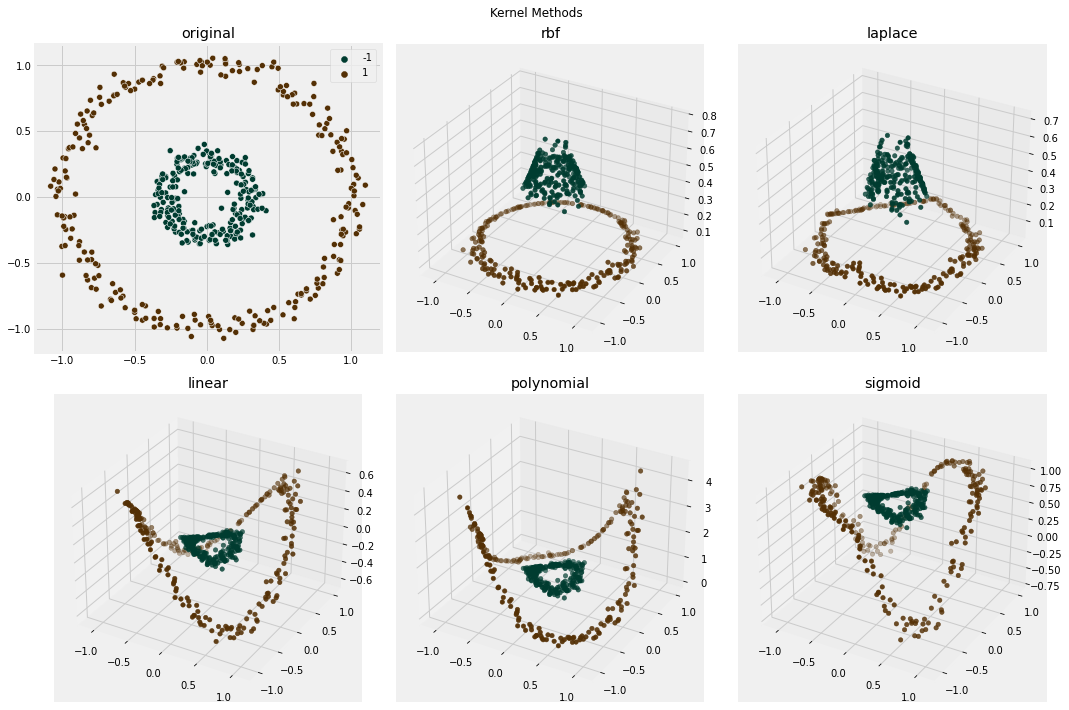

In [4]:
fig = plt.figure(figsize=(15, 10))


ax1 = fig.add_subplot(2, 3, 1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, ax=ax1, palette='BrBG_r')
ax1.set_title("original")

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
trans_X = np.c_[X, Kernel('rbf')(X)]
ax2.scatter(trans_X[:, 0], trans_X[:, 1], trans_X[:, 2], c=y, cmap='BrBG_r')
ax2.set_title("rbf")

ax3 = fig.add_subplot(2, 3, 3, projection='3d')
trans_X = np.c_[X, Kernel('laplace')(X)]
ax3.scatter(trans_X[:, 0], trans_X[:, 1], trans_X[:, 2], c=y, cmap='BrBG_r')
ax3.set_title("laplace")

ax4 = fig.add_subplot(2, 3, 4, projection='3d')
trans_X = np.c_[X, Kernel('linear')(X)]
ax4.scatter(trans_X[:, 0], trans_X[:, 1], trans_X[:, 2], c=y, cmap='BrBG_r')
ax4.set_title("linear")

ax5 = fig.add_subplot(2, 3, 5, projection='3d')
trans_X = np.c_[X, Kernel('polynomial')(X)]
ax5.scatter(trans_X[:, 0], trans_X[:, 1], trans_X[:, 2], c=y, cmap='BrBG_r')
ax5.set_title("polynomial")

ax6 = fig.add_subplot(2, 3, 6, projection='3d')
trans_X = np.c_[X, Kernel('sigmoid')(X)]
ax6.scatter(trans_X[:, 0], trans_X[:, 1], trans_X[:, 2], c=y, cmap='BrBG_r')
ax6.set_title("sigmoid")

plt.suptitle("Kernel Methods")
plt.tight_layout()
plt.show()

In [5]:
np.random.seed(0)

class SVM:
    def __init__(self, n_iter = 100, lambda_param = 0.01, learning_rate = 0.001, kernel=None, kernel_args=None, kernel_kwargs=None):
        self.n_iter = n_iter
        self.lambda_param = lambda_param
        self.learning_rate = learning_rate
        self.w = None
        self.b = None
        self.l_loss = None
        self.kernel = kernel
        self.kernel_args = kernel_args or []
        self.kernel_kwargs = kernel_kwargs or {}
        
    @property
    def margin(self):
        return 1 / np.linalg.norm(self.w)
    
    @property
    def loss(self):
        return self.l_loss
    
    def _predict(self, X, *args, **kwargs):
        return np.sign((self.w @ X.T) + self.b)
                        
    def predict(self, X):
        X = self._apply_kernel(X)
        return self._predict(X)
    
    def _apply_kernel(self, X):
        if self.kernel is not None:
            X = np.c_[X, Kernel(self.kernel)(X, *self.kernel_args, **self.kernel_kwargs)]
        return X
    
    def fit(self, X, y):
        X = self._apply_kernel(X)
        
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features) # np.random.rand(n_features)
        self.b = 0
        self.l_loss = []
        
        for _ in range(self.n_iter):
            for i in range(n_samples):
                if (y[i] * ((self.w @ X[i, :].T) + self.b)) >= 1:
                    self.w = self.w - ( self.learning_rate * (2 * self.lambda_param * self.w))
                else:
                    self.w = self.w - ( self.learning_rate * (( 2 * self.lambda_param * self.w ) - (y[i] * X[i, :])))
                    self.b = self.b + ( self.learning_rate * y[i] )
                    
                new_loss = metrics.hinge_loss(y, self._predict(X))
                self.l_loss.append(new_loss)
    
    def plot(self, X):
        # np.random.seed(10)

        y_pred = self.predict(X)

        fig, ax = plt.subplots(1, 2, figsize=(15, 7))

        xx, yy = np.meshgrid(np.linspace(X[:, 0].min() , X[:, 0].max(), 1000),np.linspace(X[:, 1].min() , X[:, 1].max(), 1000))
        mesh = np.c_[xx.ravel(), yy.ravel()]
        mesh_pred = self.predict(mesh)
        zz = mesh_pred.reshape(xx.shape)


        ax[0].contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.2)
        sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, style=y, ax=ax[0], palette='deep')

        ax[0].legend()
        ax[0].set_title("Dicision Boundary - Hyperplane")

        ax[1].plot(self.loss)
        ax[1].set_title("Loss over iterations")

        plt.show()


### Without Kernel

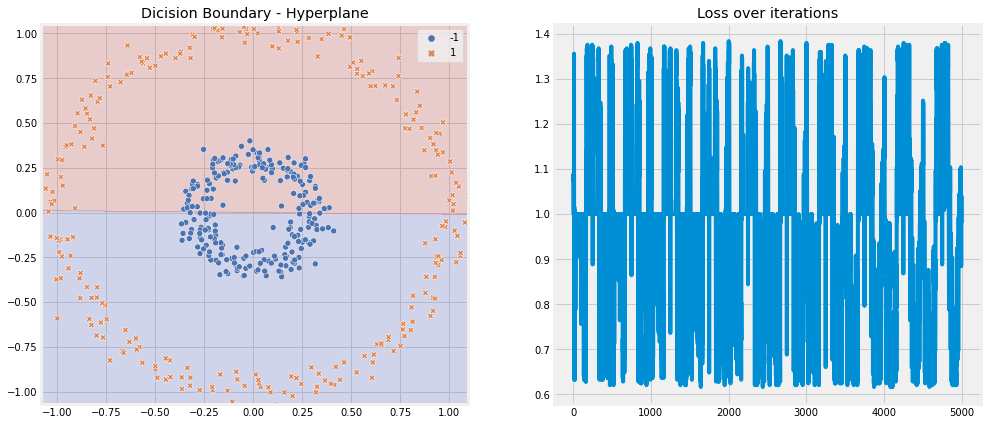

In [6]:
model = SVM(n_iter=10, lambda_param=0.001, learning_rate=0.01)
model.fit(X, y)

model.plot(X)

### RBF Kernel

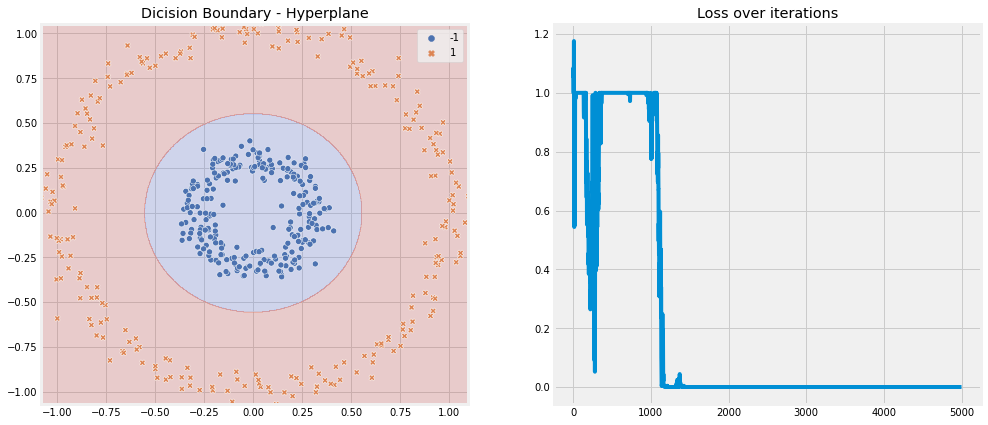

In [7]:
model = SVM(n_iter=10, lambda_param=0.001, learning_rate=0.01, kernel='rbf', kernel_kwargs={"gamma" : 2})
model.fit(X, y)

model.plot(X)

### Laplace Kernel

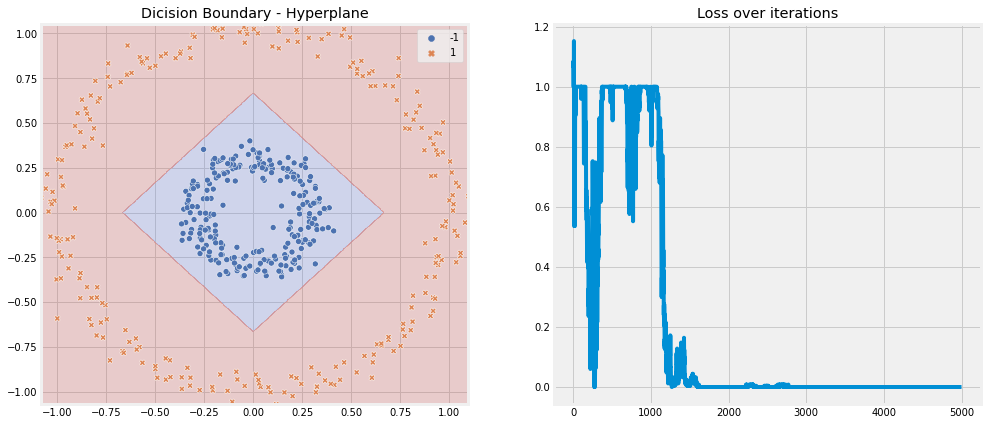

In [8]:
model = SVM(n_iter=10, lambda_param=0.001, learning_rate=0.01, kernel='laplace')
model.fit(X, y)

model.plot(X)

### Polynomial Kernel

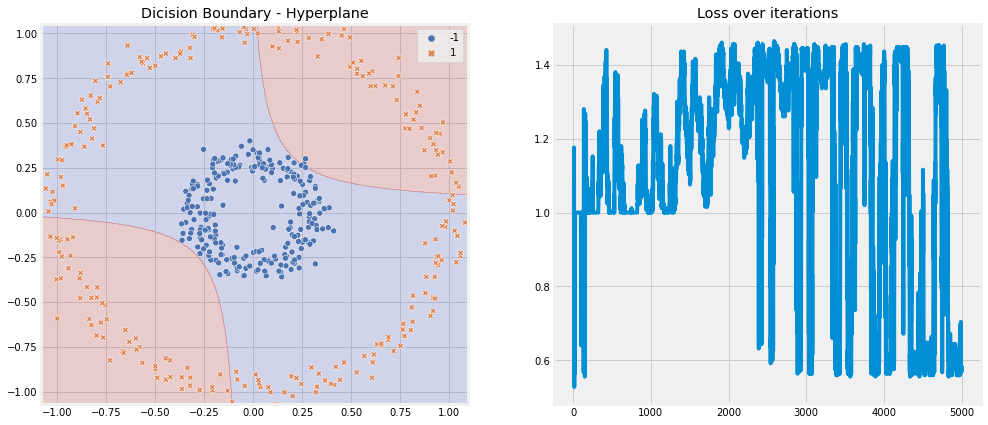

In [9]:
model = SVM(n_iter=10, lambda_param=0.001, learning_rate=0.01, kernel='polynomial', kernel_kwargs={"d" : 2})
model.fit(X, y)

model.plot(X)

### Linear Kernel

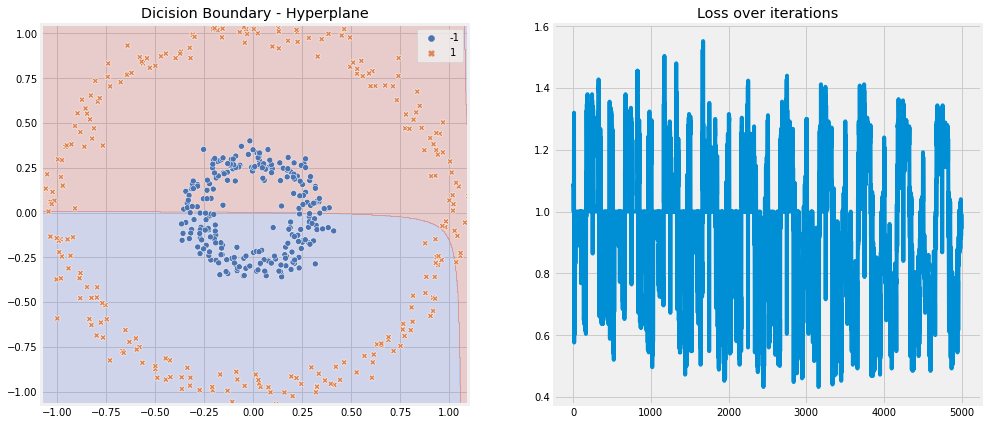

In [10]:
model = SVM(n_iter=10, lambda_param=0.001, learning_rate=0.01, kernel='linear')
model.fit(X, y)

model.plot(X)

### Sigmoid Kernel

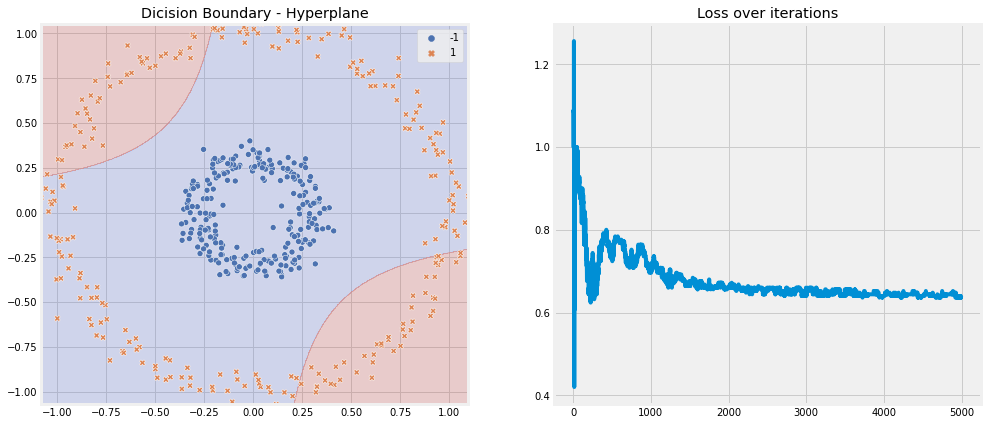

In [11]:
model = SVM(n_iter=10, lambda_param=0.001, learning_rate=0.01, kernel='sigmoid')
model.fit(X, y)

model.plot(X)

In [12]:
# fig= plt.figure(figsize=(15, 7))

# xx, yy = np.meshgrid(np.linspace(X[:, 0].min() , X[:, 0].max(), 500),np.linspace(X[:, 1].min() , X[:, 1].max(), 500))
# mesh = np.c_[xx.ravel(), yy.ravel()]
# mesh_pred = model.predict(mesh)
# zz = mesh_pred.reshape(xx.shape)


# ax1 = fig.add_subplot(1,1,1, projection='3d')
# ax1.scatter(xx, yy, zz, c=np.sign(zz), cmap='BrBG_r')

# plt.show()